This notebook will hopefully contain timeseries that plot continuous data from moorings alongside model output. 

In [1]:
import sys
sys.path.append('/ocean/kflanaga/MEOPAR/analysis-keegan/notebooks/Tools')

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import netCDF4 as nc
import xarray as xr
import datetime as dt
from salishsea_tools import evaltools as et, viz_tools
import gsw 
import matplotlib.gridspec as gridspec
import matplotlib as mpl
import matplotlib.dates as mdates
import cmocean as cmo
import scipy.interpolate as sinterp
import pickle
import cmocean
import json
import f90nml
import Keegan_eval_tools as ket
from collections import OrderedDict
from matplotlib.colors import LogNorm

fs=16
mpl.rc('xtick', labelsize=fs)
mpl.rc('ytick', labelsize=fs)
mpl.rc('legend', fontsize=fs)
mpl.rc('axes', titlesize=fs)
mpl.rc('axes', labelsize=fs)
mpl.rc('figure', titlesize=fs)
mpl.rc('font', size=fs)
mpl.rc('font', family='sans-serif', weight='normal', style='normal')

import warnings
#warnings.filterwarnings('ignore')
from IPython.display import Markdown, display

%matplotlib inline

In [3]:
saveloc='/ocean/kflanaga/MEOPAR/mooredData'
year=2015
Mooring='Dockton'

In [4]:
##### Loading in pickle file data
with open(os.path.join(saveloc,f'daily_data_{Mooring}_{year}.pkl'),'rb') as hh:
    data=pickle.load(hh)

In [5]:
%%time
start= dt.datetime(year,1,1)
end=dt.datetime(year,12,31) # the code called below (evaltools.index_model_files) includes the end date 
                          # in the values returned
basedir='/results2/SalishSea/nowcast-green.201905/'
nam_fmt='nowcast'
flen=1 # files contain 1 day of data each
ftype= 'grid_T' # load grid files
tres=24 # 1: hourly resolution; 24: daily resolution   <- try changing to 1 and loading hourly data
flist=et.index_model_files(start,end,basedir,nam_fmt,flen,ftype,tres)
# flist contains paths: file pathes; t_0 timestemp of start of each file; t_n: timestamp of start of next file

#Loading the coordinate data for the different stations
jjii = xr.open_dataset('/ocean/kflanaga/MEOPAR/grid/grid_from_lat_lon_mask999.nc')


CPU times: user 24 ms, sys: 44 ms, total: 68 ms
Wall time: 701 ms


In [6]:
def get_ij(lat,lon):
    method = 'nearest'
    jj = jjii.jj.sel(lats=lat, lons=lon, method=method).item()
    ii = jjii.ii.sel(lats=lat, lons=lon, method=method).item()
    return ii, jj

In [8]:
# get model i,j of location S3 from places
ii,ij=get_ij(data['Lat'].unique(),data['Lon'].unique())
ik=7 # choose surface level


In [9]:
grid=xr.open_mfdataset(flist['paths'])

In [10]:
%%time
tt=grid.time_counter
vot=grid.votemper.isel(deptht=ik,y=ij,x=ii)
vos=grid.vosaline.isel(deptht=ik,y=ij,x=ii)

CPU times: user 4 ms, sys: 0 ns, total: 4 ms
Wall time: 4.43 ms


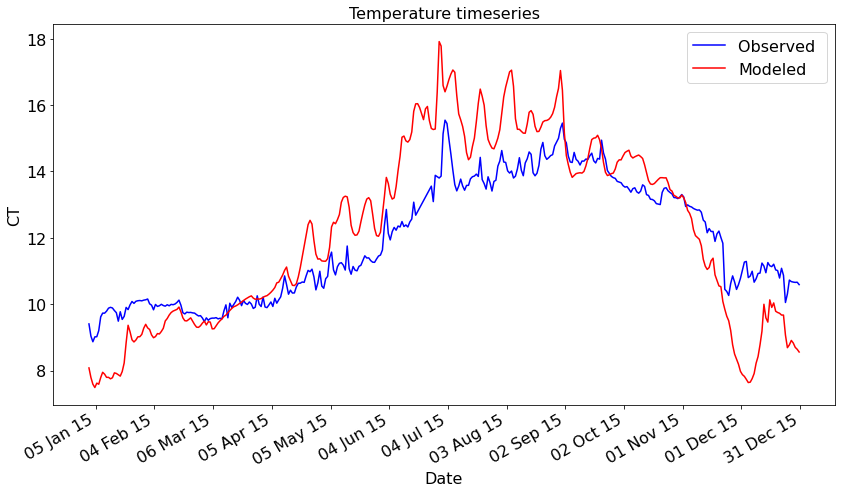

In [11]:
obsvar='CT'
start_date=dt.datetime(year,1,1)
end_date=dt.datetime(year,12,31)
obs0=et._deframe(data.loc[(data['dtUTC'] >= start_date)&(data['dtUTC']<= end_date)&(data['SA'] > 10),[obsvar]])
time0=et._deframe(data.loc[(data['dtUTC'] >= start_date)&(data['dtUTC']<= end_date)&(data['SA'] > 10),['dtUTC']])
fig,ax=plt.subplots(1,1,figsize=(14,7))

ps=[]
p0,=ax.plot(time0,obs0,'-',color='blue',label=f'Observed ')
ps.append(p0)
p0,=ax.plot(tt,vot,'-',color='red',label='Modeled')
ps.append(p0)
ax.legend(handles=ps)
ax.set_ylabel(f'{obsvar}')
ax.set_xlabel('Date')
ax.set_title('Temperature timeseries')
plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')
M = 15
xticks = mpl.ticker.MaxNLocator(M)
ax.xaxis.set_major_locator(xticks)
yearsFmt = mdates.DateFormatter('%d %b %y')
ax.xaxis.set_major_formatter(yearsFmt)

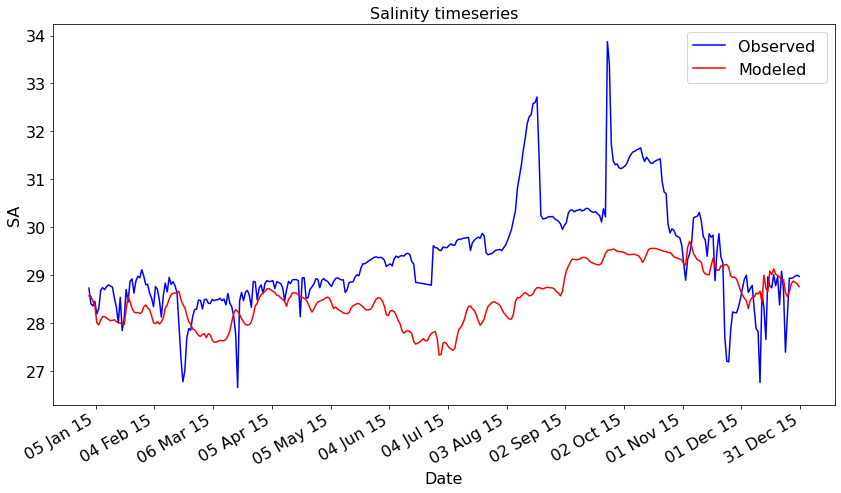

In [12]:
obsvar='SA'
start_date=dt.datetime(year,1,1)
end_date=dt.datetime(year,12,31)
obs0=et._deframe(data.loc[(data['dtUTC'] >= start_date)&(data['dtUTC']<= end_date)&(data['SA'] > 10),[obsvar]])
time0=et._deframe(data.loc[(data['dtUTC'] >= start_date)&(data['dtUTC']<= end_date)&(data['SA'] > 10),['dtUTC']])
fig,ax=plt.subplots(1,1,figsize=(14,7))

ps=[]
p0,=ax.plot(time0,obs0,'-',color='blue',label=f'Observed ')
ps.append(p0)
p0,=ax.plot(tt,vos,'-',color='red',label='Modeled')
ps.append(p0)
ax.legend(handles=ps)
ax.set_ylabel(f'{obsvar}')
ax.set_xlabel('Date')
ax.set_title('Salinity timeseries')
plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')
M = 15
xticks = mpl.ticker.MaxNLocator(M)
ax.xaxis.set_major_locator(xticks)
yearsFmt = mdates.DateFormatter('%d %b %y')
ax.xaxis.set_major_formatter(yearsFmt)

In [13]:
grid.close()

In [14]:
%%time
start= dt.datetime(year,1,1)
end=dt.datetime(year,12,31) # the code called below (evaltools.index_model_files) includes the end date 
                          # in the values returned
basedir='/results2/SalishSea/nowcast-green.201905/'
nam_fmt='nowcast'
flen=1 # files contain 1 day of data each
ftype= 'ptrc_T' # load bio files
tres=24 # 1: hourly resolution; 24: daily resolution   <- try changing to 1 and loading hourly data
flist=et.index_model_files(start,end,basedir,nam_fmt,flen,ftype,tres)
# flist contains paths: file pathes; t_0 timestemp of start of each file; t_n: timestamp of start of next file

#opening biological data files.
bio=xr.open_mfdataset(flist['paths'])

CPU times: user 13.1 s, sys: 1.77 s, total: 14.8 s
Wall time: 3min 15s


In [15]:
%%time
tt=bio.time_counter
diatom=bio.diatoms.isel(deptht=ik,y=ij,x=ii)
flagellate=bio.flagellates.isel(deptht=ik,y=ij,x=ii)
ciliate=bio.ciliates.isel(deptht=ik,y=ij,x=ii)
mod_Chl=(diatom+flagellate+ciliate)*1.8

CPU times: user 8 ms, sys: 0 ns, total: 8 ms
Wall time: 10.5 ms


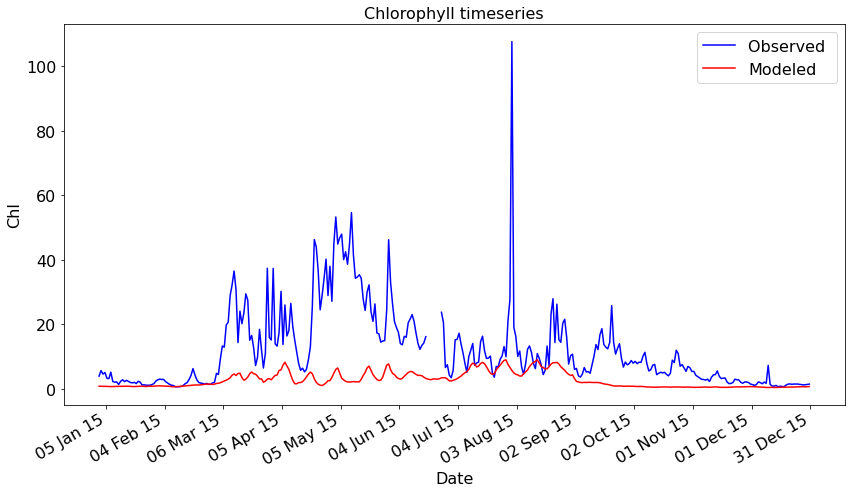

In [16]:
obsvar='Chl'
start_date=dt.datetime(year,1,1)
end_date=dt.datetime(year,12,31)
obs0=et._deframe(data.loc[(data['dtUTC'] >= start_date)&(data['dtUTC']<= end_date),[obsvar]])
time0=et._deframe(data.loc[(data['dtUTC'] >= start_date)&(data['dtUTC']<= end_date),['dtUTC']])
fig,ax=plt.subplots(1,1,figsize=(14,7))

ps=[]
p0,=ax.plot(time0,obs0,'-',color='blue',label=f'Observed ')
ps.append(p0)
p0,=ax.plot(tt,mod_Chl,'-',color='red',label='Modeled')
ps.append(p0)
ax.legend(handles=ps)
ax.set_ylabel(f'{obsvar}')
ax.set_xlabel('Date')
ax.set_title('Chlorophyll timeseries')
plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')
M = 15
xticks = mpl.ticker.MaxNLocator(M)
ax.xaxis.set_major_locator(xticks)
yearsFmt = mdates.DateFormatter('%d %b %y')
ax.xaxis.set_major_formatter(yearsFmt)

In [17]:
bio.close()